In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris

# Load the Iris dataset
iris_data = load_iris()
iris_df = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris_df_original = iris_df.copy()

# Introduce MAR missingness
def introduce_mar_missingness(df, target_cols, conditioning_col, missing_frac=0.3):
    df_missing = df.copy()
    for col in target_cols:
        sorted_indices = df_missing[conditioning_col].sort_values().index
        n_missing = int(len(df_missing) * missing_frac)
        missing_indices = sorted_indices[-n_missing:]
        df_missing.loc[missing_indices, col] = np.nan
    return df_missing

target_features = ['petal length (cm)', 'petal width (cm)']
conditioning_feature = 'sepal length (cm)'
iris_df_missing = introduce_mar_missingness(iris_df, target_features, conditioning_feature, missing_frac=0.3)
print("Number of missing values per column:")
print(iris_df_missing.isnull().sum())


Number of missing values per column:
sepal length (cm)     0
sepal width (cm)      0
petal length (cm)    45
petal width (cm)     45
dtype: int64


In [ ]:
# Part A: Library imports
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from functools import reduce

# optional: display settings
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 40)


In [ ]:


def introduce_mar_missingness(df, target_cols, conditioning_col, missing_frac=0.3, random_state=42):
    df_missing = df.copy()
    np.random.seed(random_state)

    for col in target_cols:
        # probability proportional to conditioning_col (scaled)
        prob_missing = (df_missing[conditioning_col] - df_missing[conditioning_col].min()) / \
                       (df_missing[conditioning_col].max() - df_missing[conditioning_col].min())
        prob_missing = prob_missing / prob_missing.sum() * (len(df) * missing_frac)
        mask = np.random.rand(len(df)) < prob_missing
        df_missing.loc[mask, col] = np.nan

    return df_missing

# Load original Iris data
iris_data = load_iris()
iris_df_original = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)

# Introduce MAR missingness
target_features = ['petal length (cm)', 'petal width (cm)']
conditioning_feature = 'sepal length (cm)'
iris_df_missing = introduce_mar_missingness(iris_df_original, target_features, conditioning_feature, missing_frac=0.3)

# Quick prints
print("--- Data Preparation ---")
print("Original Data Head:")
print(iris_df_original.head())
print("\nData with Missing Values Head:")
print(iris_df_missing.head())
print("\nNumber of missing values per column:")
print(iris_df_missing.isnull().sum())
print("-" * 30)


--- Data Preparation ---
Original Data Head:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

Data with Missing Values Head:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

Number of 

In [ ]:
# Mean and Median Imputation
mean_imputer = SimpleImputer(strategy='mean')
iris_df_mean_imputed = pd.DataFrame(mean_imputer.fit_transform(iris_df_missing), columns=iris_df_original.columns)

median_imputer = SimpleImputer(strategy='median')
iris_df_median_imputed = pd.DataFrame(median_imputer.fit_transform(iris_df_missing), columns=iris_df_original.columns)

# EM Algorithm Implementation
def impute_em(X, max_iter=150, eps=1e-5):
    X = np.array(X, dtype=float)
    nr, nc = X.shape
    C_obs = ~np.isnan(X)

    # Initialization
    mu = np.nanmean(X, axis=0)
    observed_rows = np.all(C_obs, axis=1)
    if np.sum(observed_rows) < nc:
        Sigma = np.diag(np.nanvar(X, axis=0))
    else:
        Sigma = np.cov(X[observed_rows, :], rowvar=False)

    log_likelihood_history = []
    for iteration in range(max_iter):
        X_imputed = X.copy()
        S_tilde = np.zeros_like(Sigma)

        # E-Step
        for i in range(nr):
            obs_indices = C_obs[i, :]
            mis_indices = ~obs_indices

            if np.any(mis_indices):
                mu_obs, mu_mis = mu[obs_indices], mu[mis_indices]
                Sigma_obs_obs = Sigma[np.ix_(obs_indices, obs_indices)]
                Sigma_mis_obs = Sigma[np.ix_(mis_indices, obs_indices)]
                Sigma_obs_mis = Sigma_mis_obs.T
                Sigma_mis_mis = Sigma[np.ix_(mis_indices, mis_indices)]
                try:
                    Sigma_obs_obs_inv = np.linalg.inv(Sigma_obs_obs)
                except np.linalg.LinAlgError:
                    # add tiny regularizer if singular
                    Sigma_obs_obs_inv = np.linalg.inv(Sigma_obs_obs + 1e-6*np.eye(Sigma_obs_obs.shape[0]))
                x_obs = X[i, obs_indices]

                expected_mis_values = mu_mis + Sigma_mis_obs @ Sigma_obs_obs_inv @ (x_obs - mu_obs)
                X_imputed[i, mis_indices] = expected_mis_values

                cond_cov_mis = Sigma_mis_mis - Sigma_mis_obs @ Sigma_obs_obs_inv @ Sigma_obs_mis
                S_tilde[np.ix_(mis_indices, mis_indices)] += cond_cov_mis

        # M-Step
        mu = np.mean(X_imputed, axis=0)
        Sigma = np.cov(X_imputed, rowvar=False, bias=True) + (S_tilde / nr)

        # Convergence Check (log-likelihood on observed parts)
        log_likelihood = 0
        for i in range(nr):
            obs_indices = C_obs[i, :]
            if np.any(obs_indices):
                try:
                    mu_obs = mu[obs_indices]
                    Sigma_obs_obs = Sigma[np.ix_(obs_indices, obs_indices)]
                    x_obs = X[i, obs_indices]
                    term1 = -0.5 * len(mu_obs) * np.log(2 * np.pi)
                    sign, logdet = np.linalg.slogdet(Sigma_obs_obs)
                    if sign <= 0:
                        continue
                    term2 = -0.5 * logdet
                    term3 = -0.5 * (x_obs - mu_obs).T @ np.linalg.inv(Sigma_obs_obs) @ (x_obs - mu_obs)
                    log_likelihood += term1 + term2 + term3
                except np.linalg.LinAlgError:
                    continue

        log_likelihood_history.append(log_likelihood)
        if iteration > 0 and abs(log_likelihood - log_likelihood_history[-2]) < eps:
            print(f"EM converged at iteration {iteration+1}")
            break

    if iteration == max_iter - 1:
        print("EM reached max iterations.")

    return X_imputed, mu, Sigma, log_likelihood_history

# Apply the EM algorithm
X_missing_np = iris_df_missing.to_numpy()
X_em_imputed_np, mu_em, Sigma_em, ll_history = impute_em(X_missing_np)
iris_df_em_imputed = pd.DataFrame(X_em_imputed_np, columns=iris_df_original.columns)


EM converged at iteration 17


In [ ]:


def calculate_imputation_rmse(original_series, imputed_series, missing_mask):
    true_values = original_series[missing_mask]
    imputed_values = imputed_series[missing_mask]
    return np.sqrt(mean_squared_error(true_values, imputed_values))

# Missing masks
missing_mask_pl = iris_df_missing['petal length (cm)'].isnull()
missing_mask_pw = iris_df_missing['petal width (cm)'].isnull()

# Calculate RMSEs for Mean, Median, EM
results = {'Mean Imputation': [], 'Median Imputation': [], 'EM Algorithm': []}

# Mean
rmse_pl_mean = calculate_imputation_rmse(iris_df_original['petal length (cm)'], iris_df_mean_imputed['petal length (cm)'], missing_mask_pl)
rmse_pw_mean = calculate_imputation_rmse(iris_df_original['petal width (cm)'], iris_df_mean_imputed['petal width (cm)'], missing_mask_pw)
results['Mean Imputation'] = [rmse_pl_mean, rmse_pw_mean, np.sqrt((rmse_pl_mean**2 + rmse_pw_mean**2) / 2)]

# Median
rmse_pl_median = calculate_imputation_rmse(iris_df_original['petal length (cm)'], iris_df_median_imputed['petal length (cm)'], missing_mask_pl)
rmse_pw_median = calculate_imputation_rmse(iris_df_original['petal width (cm)'], iris_df_median_imputed['petal width (cm)'], missing_mask_pw)
results['Median Imputation'] = [rmse_pl_median, rmse_pw_median, np.sqrt((rmse_pl_median**2 + rmse_pw_median**2) / 2)]

# EM
rmse_pl_em = calculate_imputation_rmse(iris_df_original['petal length (cm)'], iris_df_em_imputed['petal length (cm)'], missing_mask_pl)
rmse_pw_em = calculate_imputation_rmse(iris_df_original['petal width (cm)'], iris_df_em_imputed['petal width (cm)'], missing_mask_pw)
results['EM Algorithm'] = [rmse_pl_em, rmse_pw_em, np.sqrt((rmse_pl_em**2 + rmse_pw_em**2) / 2)]

results_df = pd.DataFrame(results, index=['RMSE - Petal Length', 'RMSE - Petal Width', 'Overall RMSE'])
print("\n--- Quantitative Evaluation ---")
print(results_df)
print("-" * 30)



--- Quantitative Evaluation ---
                     Mean Imputation  Median Imputation  EM Algorithm
RMSE - Petal Length         2.005904           1.792763      0.538841
RMSE - Petal Width          0.838289           0.797765      0.339565
Overall RMSE                1.537267           1.387521      0.450363
------------------------------



--- Generating Visualizations ---


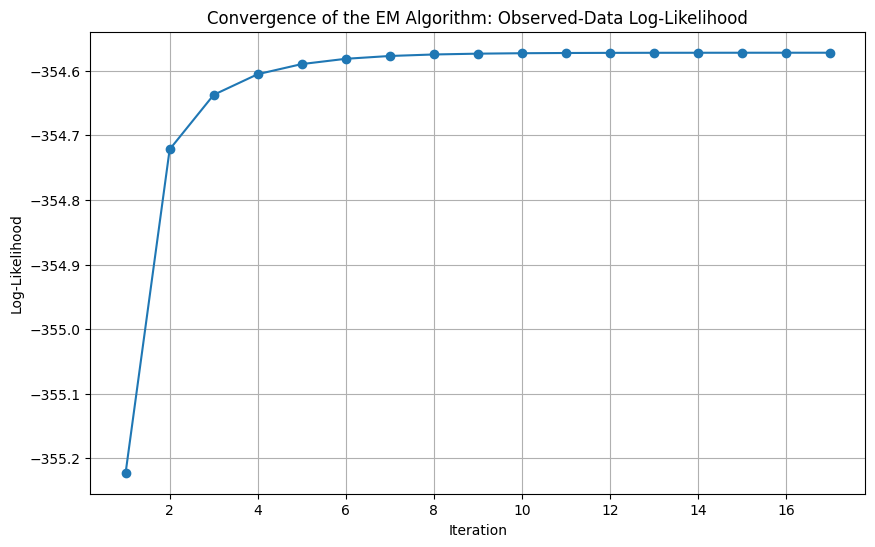

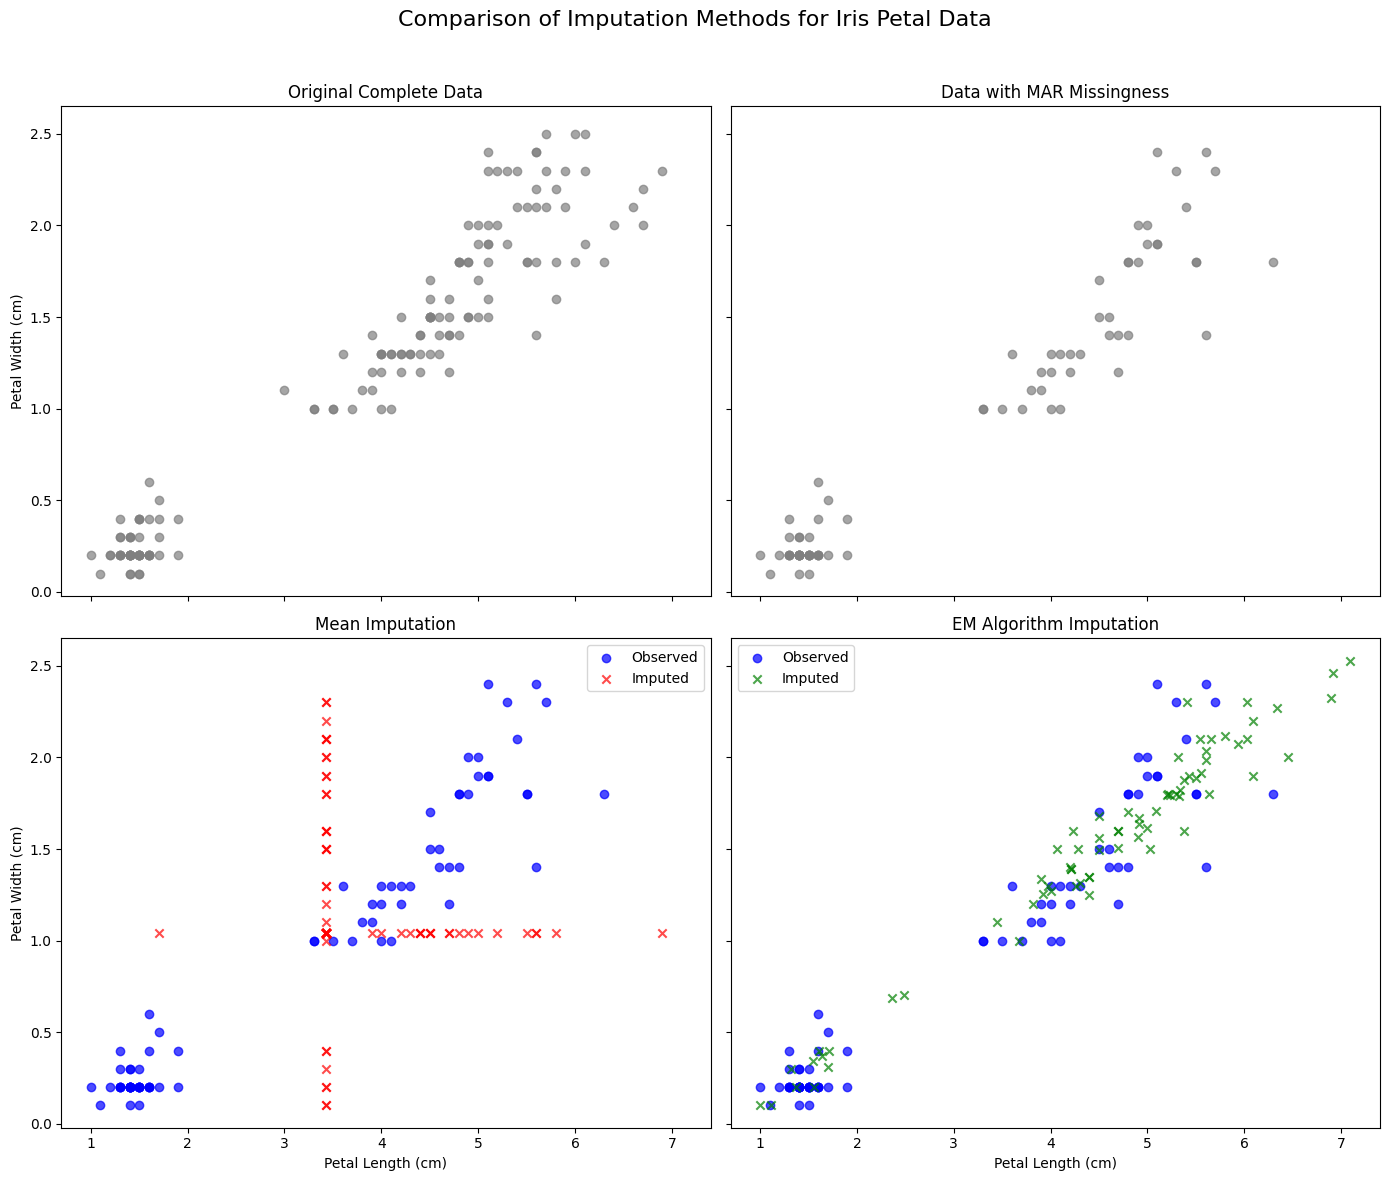

In [ ]:
print("\n--- Generating Visualizations ---")

# Convergence Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ll_history) + 1), ll_history, marker='o', linestyle='-')
plt.title('Convergence of the EM Algorithm: Observed-Data Log-Likelihood')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()

# Scatter Plot Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
fig.suptitle('Comparison of Imputation Methods for Iris Petal Data', fontsize=16)

pl_col, pw_col = 'petal length (cm)', 'petal width (cm)'

# Original Data
axes[0, 0].scatter(iris_df_original[pl_col], iris_df_original[pw_col], alpha=0.7, c='gray')
axes[0, 0].set_title('Original Complete Data')
axes[0, 0].set_ylabel('Petal Width (cm)')

# Data with Missing Values (plot existing pairs only)
# Note: to visualize the missingness pattern for pairs, we plot rows where both columns exist
both_present = iris_df_missing[pl_col].notna() & iris_df_missing[pw_col].notna()
axes[0, 1].scatter(iris_df_missing.loc[both_present, pl_col], iris_df_missing.loc[both_present, pw_col], alpha=0.7, c='gray')
axes[0, 1].set_title('Data with MAR Missingness')

# Mean Imputation
# Show observed points vs imputed points (using masks)
# Select rows where either petal length or petal width was originally missing
missing_mask_combined = missing_mask_pl | missing_mask_pw

axes[1, 0].scatter(iris_df_mean_imputed.loc[~missing_mask_combined, pl_col],
                   iris_df_mean_imputed.loc[~missing_mask_combined, pw_col],
                   c='blue', alpha=0.7, label='Observed')
axes[1, 0].scatter(iris_df_mean_imputed.loc[missing_mask_combined, pl_col],
                   iris_df_mean_imputed.loc[missing_mask_combined, pw_col],
                   c='red', alpha=0.7, label='Imputed', marker='x')
axes[1, 0].set_title('Mean Imputation')
axes[1, 0].set_xlabel('Petal Length (cm)')
axes[1, 0].set_ylabel('Petal Width (cm)')
axes[1, 0].legend()

# EM Imputation
axes[1, 1].scatter(iris_df_em_imputed.loc[~missing_mask_combined, pl_col],
                   iris_df_em_imputed.loc[~missing_mask_combined, pw_col],
                   c='blue', alpha=0.7, label='Observed')
axes[1, 1].scatter(iris_df_em_imputed.loc[missing_mask_combined, pl_col],
                   iris_df_em_imputed.loc[missing_mask_combined, pw_col],
                   c='green', alpha=0.7, label='Imputed', marker='x')
axes[1, 1].set_title('EM Algorithm Imputation')
axes[1, 1].set_xlabel('Petal Length (cm)')
axes[1, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()